# H-calls4fam_TFDS_rnn


In [ ]:
# @title
import datetime
print(datetime.datetime.now())

Similar to the example we demonstrate in the class, here are some samples of malware call sequences.

Now you need to use RNN to analysis the call sequences.

In [ ]:
import os
import pandas as pd
import numpy as np

## tfds Data

In [ ]:
# TFDS
name = "calls4fam_0522"

save_dir = "./" + name + "/"

In [ ]:
# get data from github

import requests

url = 'https://github.com/hsiaom26/DS4CS-24/raw/main/data/calls4fam_0522_tfds.tgz'

response = requests.get(url)

if response.status_code == 200:
    # Open the file for writing
    with open('calls4fam_0522_tfds.tgz', 'wb') as f:
        # Write the response content to the file
        f.write(response.content)
else:
    print('Error: Failed to download the file')

In [ ]:
!tar -zxvf calls4fam_0522_tfds.tgz

./calls4fam_0522/
./calls4fam_0522/2/
./calls4fam_0522/2/626.txt
./calls4fam_0522/2/834.txt
./calls4fam_0522/2/751.txt
./calls4fam_0522/2/866.txt
./calls4fam_0522/2/735.txt
./calls4fam_0522/2/850.txt
./calls4fam_0522/2/808.txt
./calls4fam_0522/2/847.txt
./calls4fam_0522/2/661.txt
./calls4fam_0522/2/809.txt
./calls4fam_0522/2/686.txt
./calls4fam_0522/2/638.txt
./calls4fam_0522/2/774.txt
./calls4fam_0522/2/758.txt
./calls4fam_0522/2/791.txt
./calls4fam_0522/2/631.txt
./calls4fam_0522/2/854.txt
./calls4fam_0522/2/629.txt
./calls4fam_0522/2/616.txt
./calls4fam_0522/2/889.txt
./calls4fam_0522/2/617.txt
./calls4fam_0522/2/902.txt
./calls4fam_0522/2/772.txt
./calls4fam_0522/2/837.txt
./calls4fam_0522/2/623.txt
./calls4fam_0522/2/815.txt
./calls4fam_0522/2/822.txt
./calls4fam_0522/2/648.txt
./calls4fam_0522/2/768.txt
./calls4fam_0522/2/884.txt
./calls4fam_0522/2/694.txt
./calls4fam_0522/2/745.txt
./calls4fam_0522/2/769.txt
./calls4fam_0522/2/839.txt
./calls4fam_0522/2/784.txt
./calls4fam_0522/

In [ ]:
!ls -al calls4fam_0522

total 56
drwxr-xr-x 6 root root  4096 Feb 21 04:06 .
drwxr-xr-x 1 root root  4096 Apr 10 04:52 ..
drwxr-xr-x 2 root root 12288 Feb 21 04:06 0
drwxr-xr-x 2 root root 12288 Feb 21 04:06 1
drwxr-xr-x 2 root root 12288 Feb 21 04:06 2
drwxr-xr-x 2 root root 12288 Feb 21 04:06 5


### Transform to tf.Data by utils.text_dataset_from_directory

In [ ]:
import tensorflow as tf
from tensorflow.keras import utils
import tensorflow_datasets as tfds

In [ ]:
batch_size = 32
seed = 42

train_dataset = utils.text_dataset_from_directory(
    save_dir, # from unziped dir
    labels = "inferred", # labels are generated from the directory structure
    label_mode = "int", # for sparse_categorical_crossentropy loss
    batch_size = batch_size,
    shuffle = True,
    seed = seed,
    validation_split = 0.2,
    subset = 'training', # or 'validation' to get the val dataset
    )

Found 1208 files belonging to 4 classes.
Using 967 files for training.


In [ ]:
val_dataset = utils.text_dataset_from_directory(
    save_dir,
    labels = "inferred",
    label_mode = "int",
    batch_size = batch_size,
    shuffle = True,
    seed = seed,
    validation_split = 0.2,
    subset = 'validation', # <----
    )

Found 1208 files belonging to 4 classes.
Using 241 files for validation.


In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
for example, label in train_dataset.take(1): # take 1 batch_size
  for i in range(3): # print first 3
    print('label: ', label[i].numpy())
    print('text: ', example[i].numpy())

In [ ]:
# vocab size
vocab_set = set()
separator = ' '

# classes
class_set = set()

In [ ]:
for text_batch, label_batch in train_dataset:
  for idx in range(len(text_batch)):
    # text
    line = text_batch.numpy()[idx]
    line = line.decode("utf-8")
    tokens = line.split(separator)
    for token in tokens:
      vocab_set.add(token)

    # label
    class_set.add(int(label_batch.numpy()[idx]))


print(len(vocab_set))
print(len(class_set))

121
4


### RNN

Same as
https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [ ]:
# RNN

BATCH_SIZE = batch_size # same as TFDS
VOCAB_SIZE = len(vocab_set) + 2 # one for "", one for [UNK]

num_class = len(class_set)

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens = VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'sendto', 'read', 'close', 'recvfrom', 'rtsigaction',
       'nanosleep', 'open', 'rtsigprocmask', 'mmap2', 'fstat64',
       'connect', 'mmap', 'munmap', 'mprotect', 'time', 'gettimeofday',
       'setsockopt', 'access'], dtype='<U17')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 6,  6,  9, ...,  0,  0,  0],
       [37, 77,  6, ...,  0,  0,  0],
       [57,  4, 30, ...,  0,  0,  0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'rt_sigaction rt_sigaction rt_sigprocmask execve brk access access openat fstat mmap close access openat read fstat mmap mmap mprotect mmap mmap close arch_prctl mprotect mprotect mprotect munmap getuid getgid getpid rt_sigaction geteuid brk brk getppid stat stat geteuid getegid rt_sigaction rt_sigaction rt_sigaction rt_sigaction stat stat stat stat stat stat clone wait4 SIGCHLD rt_sigreturn exit_group'
Round-trip:  rtsigaction rtsigaction rtsigprocmask execve brk access access openat fstat mmap close access openat read fstat mmap mmap mprotect mmap mmap close archprctl mprotect mprotect mprotect munmap getuid getgid getpid rtsigaction geteuid brk brk getppid stat stat geteuid getegid rtsigaction rtsigaction rtsigaction rtsigaction stat stat stat stat stat stat clone wait4 sigchld rtsigreturn exitgroup                                                                                                                                                                               

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 64,
        # Use masking to handle the variable sequence lengths
        mask_zero = True),
    # Now, try to design your RNN
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # complex nn
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # 64, change to 32 if complex nn used
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.5), # complex nn
    tf.keras.layers.Dense(num_class, activation='softmax') # from_logits=False, SparseCategoricalCrossentropy
])

In [ ]:
# print your model
model.summary()

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, # isn't it cheating?
                    )

Epoch 1/10
31/31 [==============================] - 22s 368ms/step - loss: 1.3746 - accuracy: 0.4953 - val_loss: 1.3611 - val_accuracy: 0.6266
Epoch 2/10
31/31 [==============================] - 7s 236ms/step - loss: 1.3477 - accuracy: 0.5967 - val_loss: 1.3282 - val_accuracy: 0.6598
Epoch 3/10
31/31 [==============================] - 6s 207ms/step - loss: 1.2950 - accuracy: 0.6691 - val_loss: 1.2277 - val_accuracy: 0.6598
Epoch 4/10
31/31 [==============================] - 7s 215ms/step - loss: 1.1243 - accuracy: 0.6132 - val_loss: 1.0126 - val_accuracy: 0.5560
Epoch 5/10
31/31 [==============================] - 6s 186ms/step - loss: 0.9584 - accuracy: 0.6381 - val_loss: 0.8261 - val_accuracy: 0.6349
Epoch 6/10
31/31 [==============================] - 6s 191ms/step - loss: 0.8019 - accuracy: 0.6567 - val_loss: 0.6888 - val_accuracy: 0.6556
Epoch 7/10
31/31 [==============================] - 6s 199ms/step - loss: 0.7065 - accuracy: 0.6732 - val_loss: 0.6132 - val_accuracy: 0.6598
Epoch

In [ ]:
# use val_dataset as testing dataset
test_loss, test_acc = model.evaluate(val_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 1s 69ms/step - loss: 0.5800 - accuracy: 0.7427
Test Loss: 0.5799709558486938
Test Accuracy: 0.7427386045455933


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

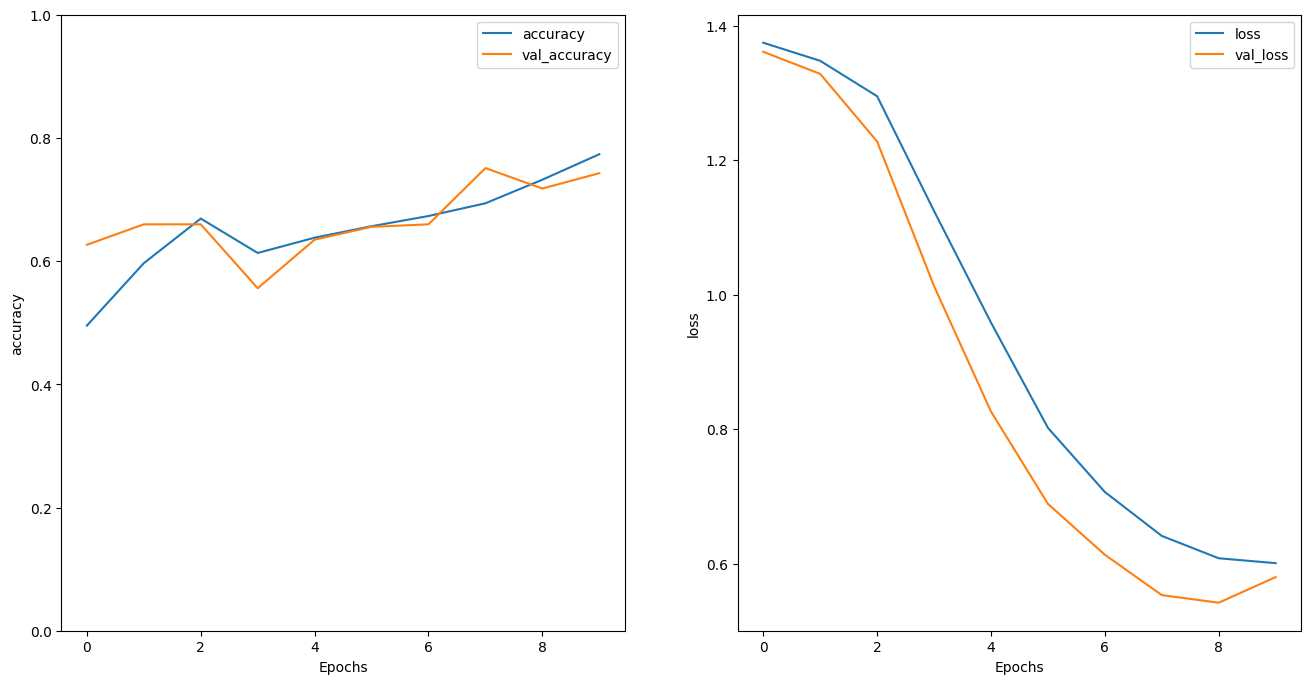

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(0.0, 1.0)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

#Question

## Q1

Change the rnn structure and make the accuracy better.

### Q1-1

Show your model summary.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          7872      
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 82436 (322.02 KB)
Trainable params: 82436 

### Q1-2

Show your confusion matrix.

## Q2

Try to use one-hot encoding and a dense neural network to classify the same dataset.

###Q2-1

Show your model summary.

###Q2-2

Show the confusion matrix of one-hot dense mdoel.


##Q3



###Q3-1

Which model performs better? Why?

###Q3-2

If you extend the input size of RNN, will the acc increase? Or there should be a sweet spot of the length?

###Q3-3

If you use one-hot two-gram or one-hot three-gram, will the dense model become better?